In [34]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp
import tensorflow as tf
import pickle
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

set_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  1


In [ ]:
sub = 3
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
path += subs[sub] + '/DATA/MAT/'
all_files = os.listdir(path)
if 'skip' in all_files:
    all_files = np.delete(all_files,all_files.index('skip'))
print(subs[sub])

In [ ]:
all_files = np.delete(all_files,0)

TR37
Set: 20160412_151530, Test: 20160412_151732, Accuracy: 80.69
Set: 20160412_151530, Test: 20160413_122728, Accuracy: 73.97
Set: 20160412_151530, Test: 20160418_120531, Accuracy: 66.89
recal: 1 20160418_120531
Missing classes
Set: 20160418_120531, Test: 20160420_053828, Accuracy: 87.35
Set: 20160418_120531, Test: 20160422_090156, Accuracy: 23.37
recal: 2 20160422_090156
Set: 20160422_090156, Test: 20160422_092607, Accuracy: 57.31
recal: 3 20160422_092607
Set: 20160422_092607, Test: 20160507_210240, Accuracy: 70.95
Set: 20160422_092607, Test: 20160507_210456, Accuracy: 84.28
ld 3
Set: 20160412_151530, Test: 20160412_151732, Accuracy: 80.69
Set: 20160412_151530, Test: 20160413_122728, Accuracy: 73.97
Set: 20160412_151530, Test: 20160418_120531, Accuracy: 66.89
Missing classes
Set: 20160412_151530, Test: 20160420_053828, Accuracy: 80.58
Set: 20160412_151530, Test: 20160422_090156, Accuracy: 23.43
Set: 20160412_151530, Test: 20160422_092607, Accuracy: 47.84
Set: 20160412_151530, Test: 2

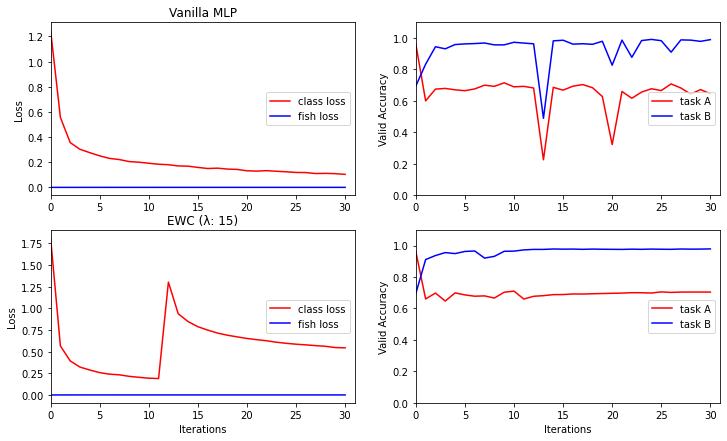

Missing classes
Set: 20160418_120531, Test: 20160420_053828, Accuracy: 87.92
Set: 20160418_120531, Test: 20160422_090156, Accuracy: 32.01
recal: 2 20160422_090156
Initial val acc 0: 0.9787, val acc 1: 0.3300
Final val acc 0: 0.6585, val acc 1: 0.8256
Initial val acc 0: 0.9787, val acc 1: 0.3300
loss:2.0188477, fish: 3.5271616e-05, lam: 0, rat: 57237.176
loss:1.4768138, fish: 0.00018422963, lam: 0, rat: 8016.1577
loss:1.2736169, fish: 0.00033759527, lam: 0, rat: 3772.6147
loss:1.2323221, fish: 0.00044287354, lam: 0, rat: 2782.5598
loss:1.1785945, fish: 0.00052005745, lam: 0, rat: 2266.2773
loss:1.0690275, fish: 0.00060197274, lam: 0, rat: 1775.8737
loss:1.0434206, fish: 0.0006602509, lam: 0, rat: 1580.3395
loss:0.9886079, fish: 0.0007218034, lam: 0, rat: 1369.636
loss:0.95333195, fish: 0.0007933802, lam: 0, rat: 1201.6079
loss:0.91977346, fish: 0.00086138025, lam: 0, rat: 1067.7903
loss:0.9118857, fish: 0.00093032233, lam: 15, rat: 980.1825
loss:6.3167405, fish: 0.0009690051, lam: 15, r

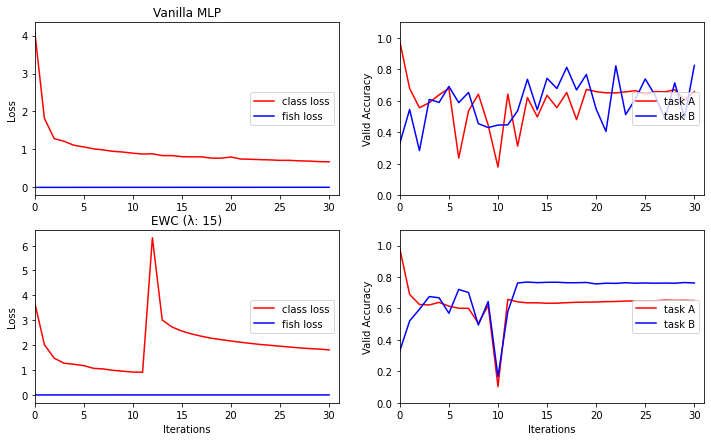

Set: 20160422_090156, Test: 20160422_092607, Accuracy: 53.36
recal: 3 20160422_092607
Initial val acc 0: 0.7621, val acc 1: 0.6127
Final val acc 0: 0.5102, val acc 1: 0.8272
Initial val acc 0: 0.7621, val acc 1: 0.6127
loss:1.0261761, fish: 2.253388e-05, lam: 0, rat: 45539.254
loss:0.91343045, fish: 0.0001266239, lam: 0, rat: 7213.7285
loss:0.8332234, fish: 0.0002477908, lam: 0, rat: 3362.6084
loss:0.8158516, fish: 0.00035291258, lam: 0, rat: 2311.7668
loss:0.7646474, fish: 0.00041002838, lam: 0, rat: 1864.8646
loss:0.7265031, fish: 0.00045085803, lam: 0, rat: 1611.3788
loss:0.70164144, fish: 0.00046633006, lam: 0, rat: 1504.6027
loss:0.6857619, fish: 0.00048986526, lam: 0, rat: 1399.899
loss:0.6606208, fish: 0.00051414105, lam: 0, rat: 1284.9019
loss:0.64626867, fish: 0.0005359282, lam: 0, rat: 1205.8867
loss:0.62075716, fish: 0.0005434108, lam: 15, rat: 1142.3351
loss:3.404646, fish: 0.0005644968, lam: 15, rat: 6031.2935
loss:2.4005532, fish: 0.00056095753, lam: 15, rat: 4279.385
los

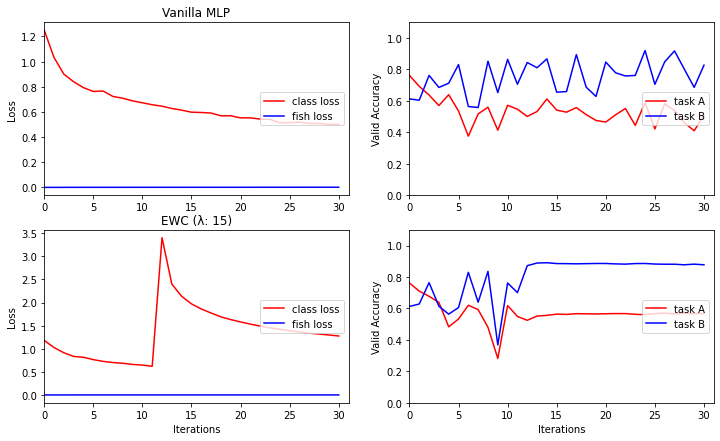

Set: 20160422_092607, Test: 20160507_210240, Accuracy: 68.66
recal: 4 20160507_210240
Initial val acc 0: 0.8777, val acc 1: 0.6814
Final val acc 0: 0.2629, val acc 1: 0.6944
Initial val acc 0: 0.8777, val acc 1: 0.6814
loss:0.65480053, fish: 4.7952366e-05, lam: 0, rat: 13655.229
loss:0.4615575, fish: 0.00028794605, lam: 0, rat: 1602.9305
loss:0.3718734, fish: 0.0005918631, lam: 0, rat: 628.3098
loss:0.3238391, fish: 0.0008417928, lam: 0, rat: 384.7017
loss:0.2987632, fish: 0.0010434471, lam: 0, rat: 286.32327
loss:0.27170238, fish: 0.0012029399, lam: 0, rat: 225.8653
loss:0.26202446, fish: 0.0013562875, lam: 0, rat: 193.19241
loss:0.24990705, fish: 0.0014900828, lam: 0, rat: 167.71353
loss:0.24252987, fish: 0.001596956, lam: 0, rat: 151.8701
loss:0.22980456, fish: 0.0017022269, lam: 0, rat: 135.0023
loss:0.23589854, fish: 0.0018095996, lam: 15, rat: 130.35953
loss:3.19614, fish: 0.0018695798, lam: 15, rat: 1709.5499
loss:1.9814303, fish: 0.0018580222, lam: 15, rat: 1066.4191
loss:1.751

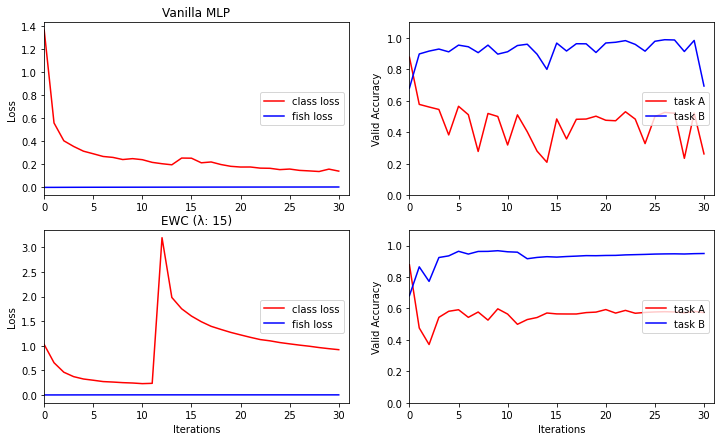

Set: 20160507_210240, Test: 20160507_210456, Accuracy: 93.02
acewcl 4
TR56
Set: 20170416_173922, Test: 20170427_125611, Accuracy: 80.64
Set: 20170416_173922, Test: 20170501_191722, Accuracy: 80.11
Set: 20170416_173922, Test: 20170503_144659, Accuracy: 83.50
Set: 20170416_173922, Test: 20170505_130044, Accuracy: 77.82
Set: 20170416_173922, Test: 20170510_131529, Accuracy: 80.06
Set: 20170416_173922, Test: 20170515_124518, Accuracy: 91.83
Set: 20170416_173922, Test: 20170603_143410, Accuracy: 82.20
Set: 20170416_173922, Test: 20170616_130839, Accuracy: 83.34
Set: 20170416_173922, Test: 20170705_130548, Accuracy: 79.59
ld 0
Set: 20170416_173922, Test: 20170427_125611, Accuracy: 80.64
Set: 20170416_173922, Test: 20170501_191722, Accuracy: 80.11
Set: 20170416_173922, Test: 20170503_144659, Accuracy: 83.50
Set: 20170416_173922, Test: 20170505_130044, Accuracy: 77.82
Set: 20170416_173922, Test: 20170510_131529, Accuracy: 80.06
Set: 20170416_173922, Test: 20170515_124518, Accuracy: 91.83
Set: 

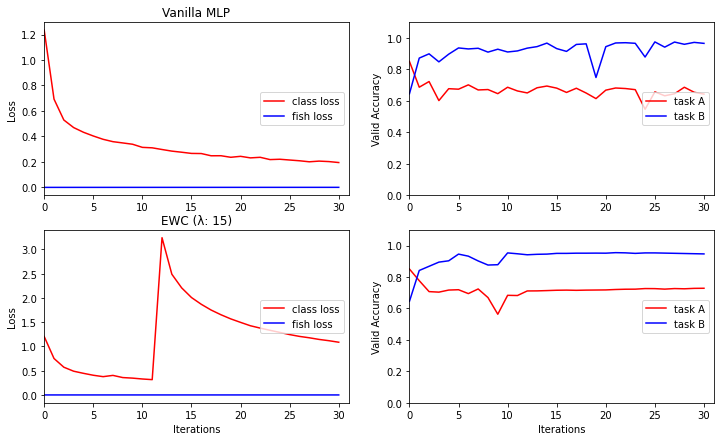

Set: 20170801_054938, Test: 20170801_065547, Accuracy: 55.04
recal: 2 20170801_065547
Initial val acc 0: 0.9469, val acc 1: 0.6557
Final val acc 0: 0.7303, val acc 1: 0.9671
Initial val acc 0: 0.9469, val acc 1: 0.6557
loss:0.64960593, fish: 5.387146e-06, lam: 0, rat: 120584.43
loss:0.5162598, fish: 2.604012e-05, lam: 0, rat: 19825.555
loss:0.44660008, fish: 5.1054703e-05, lam: 0, rat: 8747.481
loss:0.42085114, fish: 6.9274705e-05, lam: 0, rat: 6075.1055
loss:0.3803005, fish: 8.051568e-05, lam: 0, rat: 4723.3096
loss:0.37561947, fish: 9.542068e-05, lam: 0, rat: 3936.4578
loss:0.35934278, fish: 0.000110638444, lam: 0, rat: 3247.9016
loss:0.34487033, fish: 0.00012677057, lam: 0, rat: 2720.429
loss:0.33143333, fish: 0.00013507543, lam: 0, rat: 2453.6907
loss:0.31842235, fish: 0.00014990932, lam: 0, rat: 2124.0999
loss:0.33582097, fish: 0.0001667406, lam: 15, rat: 2014.0323
loss:2.4318843, fish: 0.00016898847, lam: 15, rat: 14390.83
loss:1.7150686, fish: 0.0001676206, lam: 15, rat: 10231.8

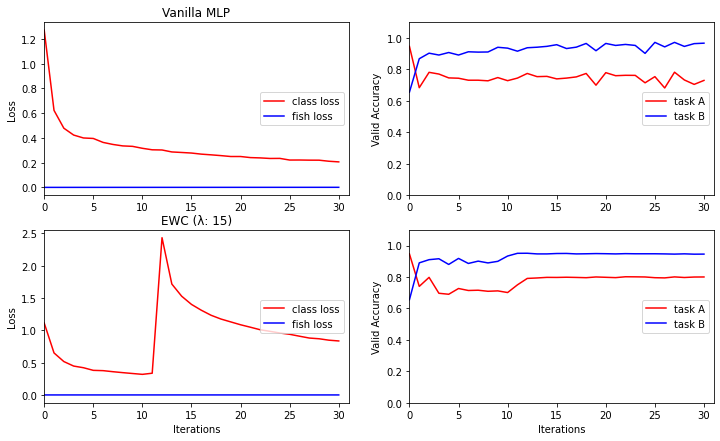

Set: 20170801_065547, Test: 20170802_050945, Accuracy: 72.06
Set: 20170801_065547, Test: 20170802_051732, Accuracy: 72.57
Set: 20170801_065547, Test: 20170802_052140, Accuracy: 77.45
Set: 20170801_065547, Test: 20170807_153152, Accuracy: 74.67
Set: 20170801_065547, Test: 20170807_153559, Accuracy: 71.98
Set: 20170801_065547, Test: 20170808_054353, Accuracy: 82.01
Set: 20170801_065547, Test: 20170808_063929, Accuracy: 78.63
Set: 20170801_065547, Test: 20170808_104400, Accuracy: 81.54
Missing classes
Set: 20170801_065547, Test: 20170913_053927, Accuracy: 42.32
recal: 3 20170913_053927
Missing classes
Initial val acc 0: 0.9456, val acc 1: 0.4617
Final val acc 0: 0.5495, val acc 1: 0.8345
Initial val acc 0: 0.9456, val acc 1: 0.4617
loss:0.7199767, fish: 6.3856e-06, lam: 0, rat: 112750.05
loss:0.45667627, fish: 3.7347716e-05, lam: 0, rat: 12227.689
loss:0.34905437, fish: 8.5665015e-05, lam: 0, rat: 4074.643
loss:0.30061156, fish: 0.00013605677, lam: 0, rat: 2209.4568
loss:0.26152876, fish:

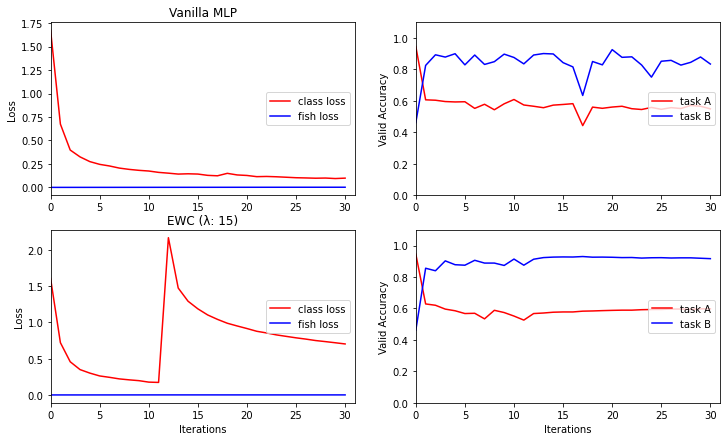

Missing classes
Set: 20170913_053927, Test: 20170913_061042, Accuracy: 86.41
Missing classes
Set: 20170913_053927, Test: 20170915_173323, Accuracy: 67.67
recal: 4 20170915_173323
Missing classes
Initial val acc 0: 0.9167, val acc 1: 0.7095
Final val acc 0: 0.7251, val acc 1: 0.9261
Initial val acc 0: 0.9167, val acc 1: 0.7095
loss:0.785646, fish: 1.8081694e-06, lam: 0, rat: 434498.03
loss:0.5909095, fish: 1.4156845e-05, lam: 0, rat: 41740.195
loss:0.49789292, fish: 4.41475e-05, lam: 0, rat: 11277.941
loss:0.4313414, fish: 7.73778e-05, lam: 0, rat: 5574.4854
loss:0.4060928, fish: 0.00011585112, lam: 0, rat: 3505.2988
loss:0.3718682, fish: 0.00016220607, lam: 0, rat: 2292.5664
loss:0.33908117, fish: 0.00020850493, lam: 0, rat: 1626.2501
loss:0.3161935, fish: 0.00025057787, lam: 0, rat: 1261.8572
loss:0.29625717, fish: 0.0002988555, lam: 0, rat: 991.3057
loss:0.27886868, fish: 0.00034120877, lam: 0, rat: 817.2963
loss:0.27072233, fish: 0.0003840817, lam: 15, rat: 704.8561
loss:2.863263, f

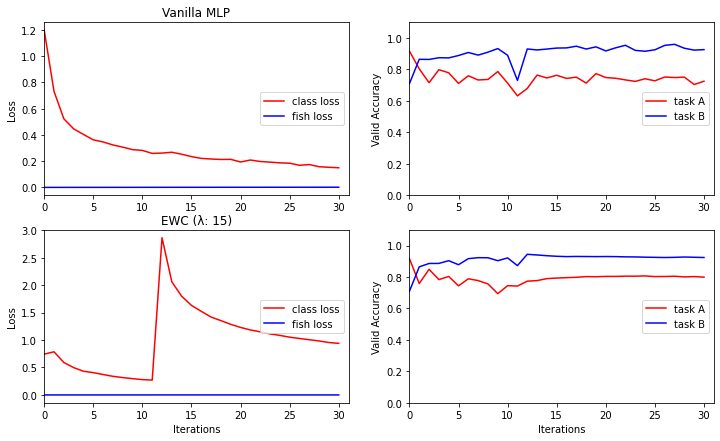

Missing classes
Set: 20170915_173323, Test: 20170916_161424, Accuracy: 86.21
Missing classes
Set: 20170915_173323, Test: 20170923_073346, Accuracy: 73.50
Missing classes
Set: 20170915_173323, Test: 20170929_051442, Accuracy: 71.79
acewcl 4
TR62
Set: 20180515_060621, Test: 20180521_090336, Accuracy: 60.18
recal: 1 20180521_090336
Set: 20180521_090336, Test: 20180524_161811, Accuracy: 74.49
Set: 20180521_090336, Test: 20180525_084201, Accuracy: 72.36
Set: 20180521_090336, Test: 20180531_073149, Accuracy: 71.79
Set: 20180521_090336, Test: 20180602_105936, Accuracy: 68.25
recal: 2 20180602_105936
Set: 20180602_105936, Test: 20180604_090437, Accuracy: 49.61
recal: 3 20180604_090437
Set: 20180604_090437, Test: 20180604_214053, Accuracy: 55.75
recal: 4 20180604_214053
Set: 20180604_214053, Test: 20180605_080547, Accuracy: 69.34
recal: 5 20180605_080547
Set: 20180605_080547, Test: 20180606_174322, Accuracy: 63.51
recal: 6 20180606_174322
Set: 20180606_174322, Test: 20180610_081839, Accuracy: 7

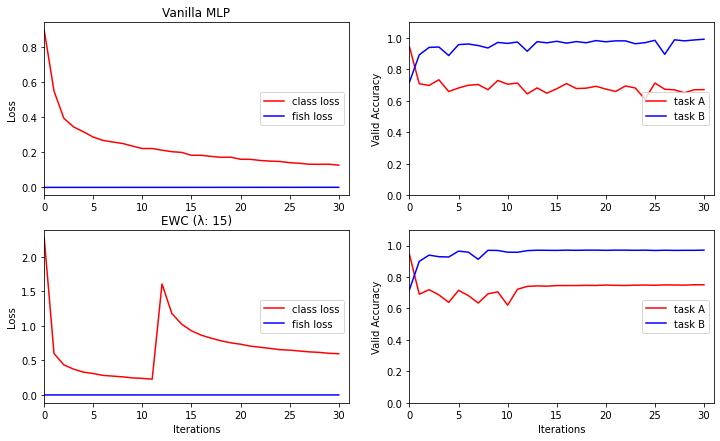

Set: 20180521_090336, Test: 20180524_161811, Accuracy: 74.18
Set: 20180521_090336, Test: 20180525_084201, Accuracy: 71.53
Set: 20180521_090336, Test: 20180531_073149, Accuracy: 73.24
Set: 20180521_090336, Test: 20180602_105936, Accuracy: 71.37
Set: 20180521_090336, Test: 20180604_090437, Accuracy: 71.53
Set: 20180521_090336, Test: 20180604_214053, Accuracy: 71.68
Set: 20180521_090336, Test: 20180605_080547, Accuracy: 69.60
recal: 2 20180605_080547
Initial val acc 0: 0.9708, val acc 1: 0.6929
Final val acc 0: 0.6465, val acc 1: 0.9979
Initial val acc 0: 0.9708, val acc 1: 0.6929
loss:0.3903103, fish: 4.5447587e-07, lam: 0, rat: 858814.1
loss:0.24430242, fish: 2.7803255e-06, lam: 0, rat: 87868.28
loss:0.18265593, fish: 6.796033e-06, lam: 0, rat: 26876.846
loss:0.16036482, fish: 1.0892794e-05, lam: 0, rat: 14722.102
loss:0.14619806, fish: 1.5178115e-05, lam: 0, rat: 9632.162
loss:0.12956841, fish: 1.9974555e-05, lam: 0, rat: 6486.6733
loss:0.12289139, fish: 2.4883875e-05, lam: 0, rat: 493

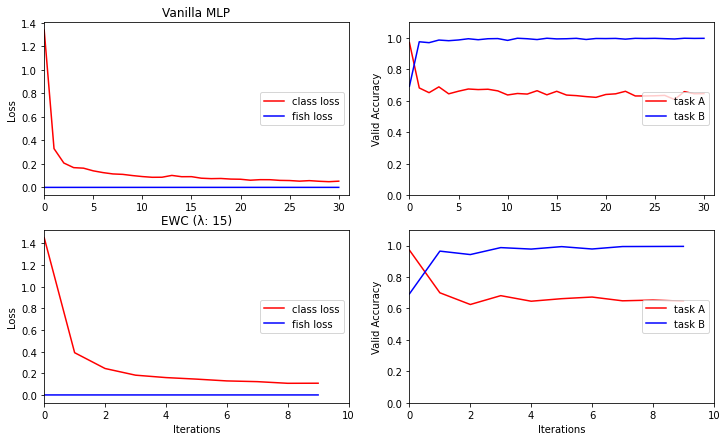

Set: 20180605_080547, Test: 20180606_174322, Accuracy: 59.50
recal: 3 20180606_174322
Initial val acc 0: 0.9948, val acc 1: 0.6096
Final val acc 0: 0.6351, val acc 1: 0.9969
Initial val acc 0: 0.9948, val acc 1: 0.6096
loss:0.70830846, fish: 3.8914763e-07, lam: 0, rat: 1820153.6
loss:0.38685894, fish: 3.198392e-06, lam: 0, rat: 120954.195
loss:0.2939098, fish: 6.7095043e-06, lam: 0, rat: 43804.992
loss:0.24593107, fish: 9.267164e-06, lam: 0, rat: 26537.898
loss:0.21710692, fish: 1.043946e-05, lam: 0, rat: 20796.758
loss:0.19394569, fish: 1.1094876e-05, lam: 0, rat: 17480.654
loss:0.17382325, fish: 1.159908e-05, lam: 0, rat: 14985.952
loss:0.15969475, fish: 1.185194e-05, lam: 0, rat: 13474.144
loss:0.15420806, fish: 1.16116225e-05, lam: 0, rat: 13280.492
loss:0.14462309, fish: 1.1438115e-05, lam: 0, rat: 12643.962
loss:0.13556619, fish: 1.1397705e-05, lam: 15, rat: 11894.166
loss:1.023458, fish: 1.1324204e-05, lam: 15, rat: 90377.92
loss:0.5657969, fish: 1.1314771e-05, lam: 15, rat: 500

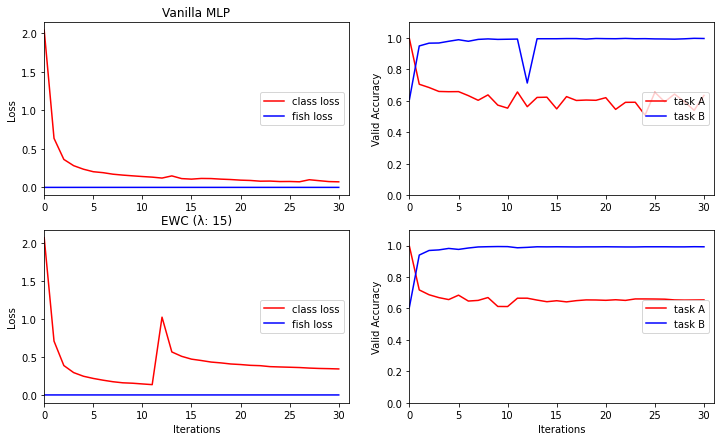

Set: 20180606_174322, Test: 20180610_081839, Accuracy: 78.76
Set: 20180606_174322, Test: 20180612_085047, Accuracy: 63.82
recal: 4 20180612_085047
Initial val acc 0: 0.9922, val acc 1: 0.6393
Final val acc 0: 0.6335, val acc 1: 0.9990
Initial val acc 0: 0.9922, val acc 1: 0.6393
loss:0.44645613, fish: 1.608194e-07, lam: 0, rat: 2776133.5
loss:0.290706, fish: 1.1459446e-06, lam: 0, rat: 253682.44
loss:0.22514197, fish: 3.2792784e-06, lam: 0, rat: 68655.945
loss:0.18445806, fish: 5.2911614e-06, lam: 0, rat: 34861.547
loss:0.16352095, fish: 7.3904926e-06, lam: 0, rat: 22125.852
loss:0.15128845, fish: 9.190887e-06, lam: 0, rat: 16460.701
loss:0.13246125, fish: 1.1158507e-05, lam: 0, rat: 11870.876
loss:0.12282906, fish: 1.2793111e-05, lam: 0, rat: 9601.1875
loss:0.116656914, fish: 1.4217054e-05, lam: 0, rat: 8205.421
loss:0.11051936, fish: 1.5712183e-05, lam: 0, rat: 7033.991
loss:0.0982801, fish: 1.715568e-05, lam: 15, rat: 5728.7207
loss:0.7726998, fish: 1.7680113e-05, lam: 15, rat: 4370

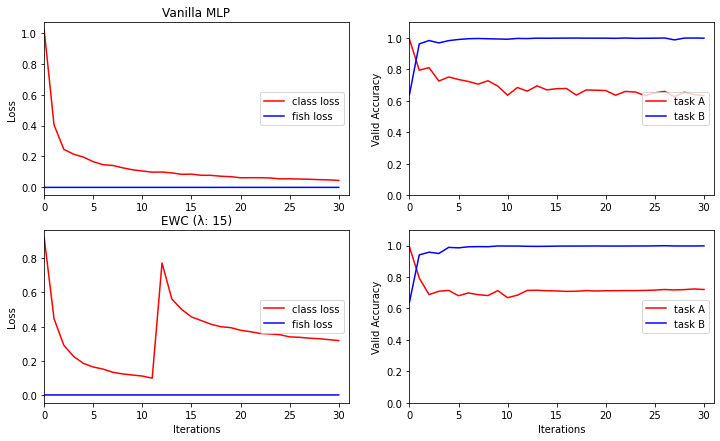

Set: 20180612_085047, Test: 20180614_081624, Accuracy: 75.53
Set: 20180612_085047, Test: 20180616_182930, Accuracy: 70.59
Set: 20180612_085047, Test: 20180617_184248, Accuracy: 60.12
recal: 5 20180617_184248
Initial val acc 0: 0.9979, val acc 1: 0.6231
Final val acc 0: 0.7553, val acc 1: 0.9719
Initial val acc 0: 0.9979, val acc 1: 0.6231
loss:0.93836504, fish: 4.4194533e-07, lam: 0, rat: 2123260.5
loss:0.649876, fish: 3.5708695e-06, lam: 0, rat: 181993.77
loss:0.49145144, fish: 6.0946486e-06, lam: 0, rat: 80636.555
loss:0.42145193, fish: 6.6900843e-06, lam: 0, rat: 62996.504
loss:0.38860124, fish: 6.918964e-06, lam: 0, rat: 56164.656
loss:0.37766528, fish: 6.804594e-06, lam: 0, rat: 55501.516
loss:0.31897402, fish: 6.8878007e-06, lam: 0, rat: 46309.996
loss:0.29344952, fish: 6.8327918e-06, lam: 0, rat: 42947.234
loss:0.2847925, fish: 6.663938e-06, lam: 0, rat: 42736.367
loss:0.25861192, fish: 6.7035508e-06, lam: 0, rat: 38578.348
loss:0.25351775, fish: 6.4218843e-06, lam: 15, rat: 394

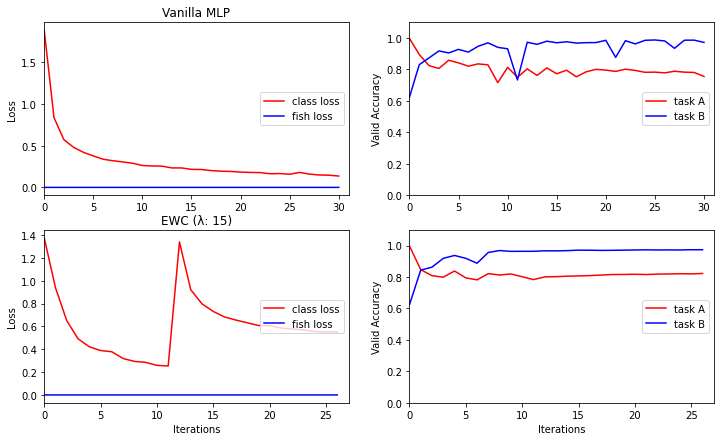

Set: 20180617_184248, Test: 20180619_193541, Accuracy: 80.48
Set: 20180617_184248, Test: 20180620_073139, Accuracy: 75.64
Set: 20180617_184248, Test: 20180620_073838, Accuracy: 71.84
Set: 20180617_184248, Test: 20180620_083903, Accuracy: 70.38
Set: 20180617_184248, Test: 20180621_094013, Accuracy: 78.71
Set: 20180617_184248, Test: 20180623_200107, Accuracy: 73.76
Set: 20180617_184248, Test: 20180703_072425, Accuracy: 71.58
Set: 20180617_184248, Test: 20180711_074144, Accuracy: 73.97
Set: 20180617_184248, Test: 20180711_113445, Accuracy: 62.99
recal: 6 20180711_113445
Initial val acc 0: 0.9735, val acc 1: 0.6377
Final val acc 0: 0.5206, val acc 1: 0.9979
Initial val acc 0: 0.9735, val acc 1: 0.6377
loss:0.67271996, fish: 3.921991e-07, lam: 0, rat: 1715251.1
loss:0.41882265, fish: 1.7916323e-06, lam: 0, rat: 233765.97
loss:0.34032068, fish: 3.2197677e-06, lam: 0, rat: 105697.27
loss:0.29899126, fish: 4.1181747e-06, lam: 0, rat: 72602.86
loss:0.26534465, fish: 4.8847955e-06, lam: 0, rat: 

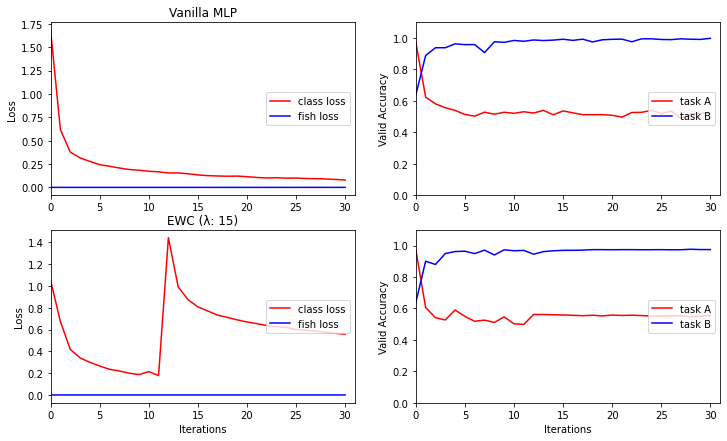

Set: 20180711_113445, Test: 20180713_102029, Accuracy: 71.73
Set: 20180711_113445, Test: 20180717_073851, Accuracy: 68.82
recal: 7 20180717_073851
Initial val acc 0: 0.9745, val acc 1: 0.6746
Final val acc 0: 0.5424, val acc 1: 0.9927
Initial val acc 0: 0.9745, val acc 1: 0.6746
loss:0.46264789, fish: 3.434396e-08, lam: 0, rat: 13471012.0
loss:0.29414093, fish: 6.5583816e-07, lam: 0, rat: 448496.22
loss:0.2376289, fish: 2.602679e-06, lam: 0, rat: 91301.66
loss:0.20041768, fish: 5.283028e-06, lam: 0, rat: 37936.14
loss:0.1809477, fish: 8.2895285e-06, lam: 0, rat: 21828.467
loss:0.1643811, fish: 1.0884661e-05, lam: 0, rat: 15102.088
loss:0.15149476, fish: 1.3585776e-05, lam: 0, rat: 11150.982
loss:0.14568284, fish: 1.6544534e-05, lam: 0, rat: 8805.497
loss:0.136812, fish: 1.8856603e-05, lam: 0, rat: 7255.3896
loss:0.12766093, fish: 2.2088772e-05, lam: 0, rat: 5779.4487
loss:0.124224484, fish: 2.4893154e-05, lam: 15, rat: 4990.307
loss:1.6457238, fish: 2.5767506e-05, lam: 15, rat: 63868.1

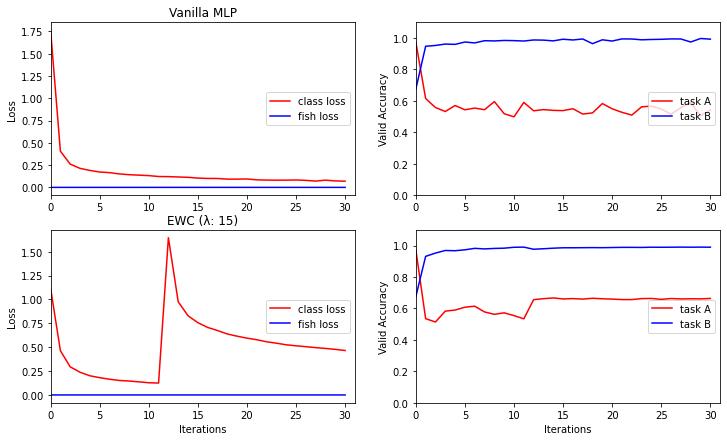

Set: 20180717_073851, Test: 20180717_112511, Accuracy: 85.68
acewcl 7
TR64
Set: 20180624_102533, Test: 20180625_204241, Accuracy: 57.25
recal: 1 20180625_204241
Set: 20180625_204241, Test: 20180627_100035, Accuracy: 73.38
Set: 20180625_204241, Test: 20180701_111306, Accuracy: 43.64
recal: 2 20180701_111306
Set: 20180701_111306, Test: 20180701_111709, Accuracy: 55.07
recal: 3 20180701_111709
Set: 20180701_111709, Test: 20180702_080237, Accuracy: 67.46
recal: 4 20180702_080237
Set: 20180702_080237, Test: 20180707_203513, Accuracy: 72.70
Set: 20180702_080237, Test: 20180709_192738, Accuracy: 79.24
Set: 20180702_080237, Test: 20180710_202633, Accuracy: 82.85
Set: 20180702_080237, Test: 20180711_210336, Accuracy: 69.98
recal: 5 20180711_210336
Set: 20180711_210336, Test: 20180721_180122, Accuracy: 84.28
Set: 20180711_210336, Test: 20180723_145156, Accuracy: 84.68
Set: 20180711_210336, Test: 20180727_170011, Accuracy: 82.71
Set: 20180711_210336, Test: 20180804_120912, Accuracy: 67.32
recal: 

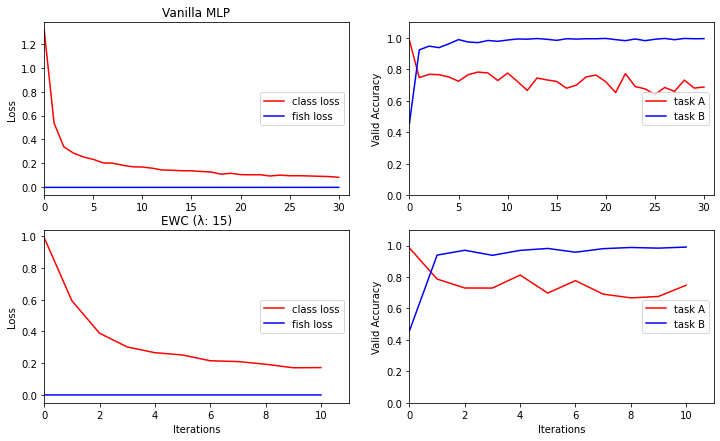

Set: 20180625_204241, Test: 20180627_100035, Accuracy: 84.00
Set: 20180625_204241, Test: 20180701_111306, Accuracy: 50.37
recal: 2 20180701_111306
Initial val acc 0: 0.9905, val acc 1: 0.5106
Final val acc 0: 0.2199, val acc 1: 0.9796
Initial val acc 0: 0.9905, val acc 1: 0.5106
loss:0.668831, fish: 3.4221603e-06, lam: 0, rat: 195441.17
loss:0.45984483, fish: 1.7775348e-05, lam: 0, rat: 25869.807
loss:0.3663304, fish: 3.6639154e-05, lam: 0, rat: 9998.331
loss:0.31786132, fish: 5.140222e-05, lam: 0, rat: 6183.805
loss:0.29122862, fish: 6.2764775e-05, lam: 0, rat: 4640.001
loss:0.26777655, fish: 7.234291e-05, lam: 0, rat: 3701.4897
loss:0.25402662, fish: 7.85292e-05, lam: 0, rat: 3234.8047
loss:0.23307559, fish: 8.550492e-05, lam: 0, rat: 2725.8733
loss:0.23036218, fish: 9.183084e-05, lam: 0, rat: 2508.549
loss:0.22745258, fish: 9.5561874e-05, lam: 0, rat: 2380.1602
loss:0.21370007, fish: 9.77435e-05, lam: 15, rat: 2186.3354
loss:1.2367072, fish: 0.00010020855, lam: 15, rat: 12341.334
lo

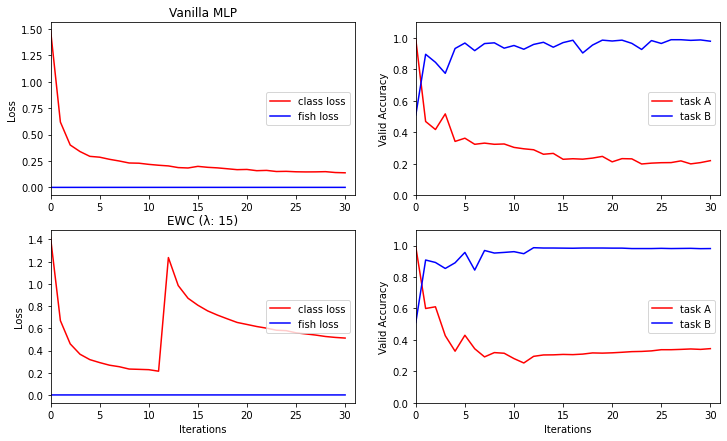

Set: 20180701_111306, Test: 20180701_111709, Accuracy: 87.61
Set: 20180701_111306, Test: 20180702_080237, Accuracy: 84.00
Set: 20180701_111306, Test: 20180707_203513, Accuracy: 80.05
Set: 20180701_111306, Test: 20180709_192738, Accuracy: 67.39
recal: 3 20180709_192738
Initial val acc 0: 0.9809, val acc 1: 0.6576
Final val acc 0: 0.5480, val acc 1: 0.9877
Initial val acc 0: 0.9809, val acc 1: 0.6576
loss:0.4244787, fish: 5.6154585e-07, lam: 0, rat: 755911.06
loss:0.25349042, fish: 3.362501e-06, lam: 0, rat: 75387.46
loss:0.20074986, fish: 6.7013966e-06, lam: 0, rat: 29956.422
loss:0.17715845, fish: 9.4216775e-06, lam: 0, rat: 18803.281
loss:0.17569488, fish: 1.1799089e-05, lam: 0, rat: 14890.546
loss:0.1550683, fish: 1.5032255e-05, lam: 0, rat: 10315.704
loss:0.14921175, fish: 1.7529834e-05, lam: 0, rat: 8511.875
loss:0.13704234, fish: 2.0107424e-05, lam: 0, rat: 6815.51
loss:0.1308013, fish: 2.2221224e-05, lam: 0, rat: 5886.323
loss:0.1417279, fish: 2.4261828e-05, lam: 0, rat: 5841.6
l

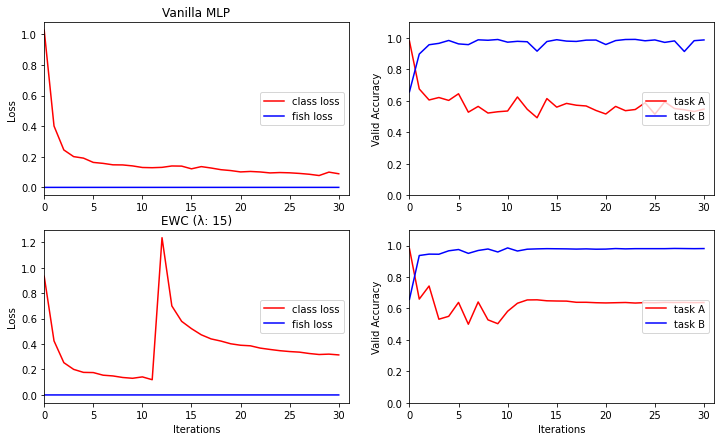

Set: 20180709_192738, Test: 20180710_202633, Accuracy: 92.17
Set: 20180709_192738, Test: 20180711_210336, Accuracy: 79.10
Set: 20180709_192738, Test: 20180721_180122, Accuracy: 84.75
Set: 20180709_192738, Test: 20180723_145156, Accuracy: 80.94
Set: 20180709_192738, Test: 20180727_170011, Accuracy: 87.88
Set: 20180709_192738, Test: 20180804_120912, Accuracy: 73.04
Set: 20180709_192738, Test: 20180805_114240, Accuracy: 78.28
Set: 20180709_192738, Test: 20180808_201758, Accuracy: 73.59
Set: 20180709_192738, Test: 20180817_190044, Accuracy: 76.24
Set: 20180709_192738, Test: 20180819_091636, Accuracy: 76.99
Set: 20180709_192738, Test: 20180828_164227, Accuracy: 70.73
Set: 20180709_192738, Test: 20180830_182937, Accuracy: 68.41
recal: 4 20180830_182937
Initial val acc 0: 0.9809, val acc 1: 0.7012
Final val acc 0: 0.7080, val acc 1: 0.9483
Initial val acc 0: 0.9809, val acc 1: 0.7012
loss:0.5922025, fish: 6.5211e-08, lam: 0, rat: 9081328.0
loss:0.4605944, fish: 3.407457e-07, lam: 0, rat: 1351

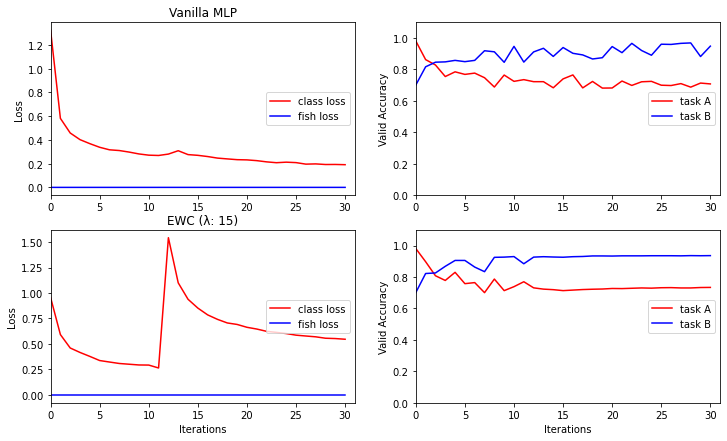

Set: 20180830_182937, Test: 20180901_180534, Accuracy: 80.74
Set: 20180830_182937, Test: 20180902_184303, Accuracy: 80.26
acewcl 4


In [36]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
bat = 32
for sub in range(5):#5):
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))
    print(subs[sub])

    mod_tot = ['ld','bld','bcnn','bcnnl','cnn','acnn','acewc', 'crcnn', 'crld','cnnl','acnnl','acnnl3','acnnl30','afcnnl','acnnlm','acewcl','acewclm']

    iter = 1
    ft = 'feat'
    recal_all = np.empty((iter,len(mod_tot),1))
    recal_all[:] = np.nan
    acc_all = np.zeros((iter,len(all_files),len(mod_tot)))
    cur_all = np.zeros((iter,len(all_files),len(mod_tot)))
    prev_all = np.zeros((iter,len(all_files),len(mod_tot)))

    for it in range(0,iter):
        with open('newest 0304/' + subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            _, _, _, _, _, _, c_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
        mod_old = cp.deepcopy(mod_all)
        if it == 0:
            mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
            eps = [0,0,0,0,5,3,30]
        else:
            # mod_all = ['cnnl','acnnl','acnnl3','acnnl30','acewcl']
            mod_all = ['cnnl','acnnl','acnnl3','acnnl30','acewcl']#,'crcnn']
            # mod_all = ['acewcl']#,'acnnl','acnnl']
            eps = [0,5,3,30,30]
        m_weights = None
        # c_weights = None
        # cl_wc = None
        mod_i = 0
        for mod in mod_all:
            acc = np.zeros((len(all_files),5))
            acc_cur = np.zeros((len(all_files),5))
            acc_prev = np.zeros((len(all_files),5))

            if 'mlp' in mod:
                acc_i = 1
            elif 'cnn' in mod:
                acc_i = 2
            elif 'mewc' in mod:
                acc_i = 3
            elif 'cewc' in mod:
                acc_i = 4
            elif 'ld' in mod:
                acc_i = 0

            mlp = None
            cnn = None
            ewc = None

            ep = 30
            recal = 0
            skip = False

            for i in range(1,len(all_files)-1):
                if i > 1:
                    if 'b' in mod:
                        skip = True
                    else:
                        if acc[i-1,acc_i] < 70:
                            skip = False
                            recal += 1
                            print('recal: ' + str(recal) + ' ' + all_files[i])
                            acc[i-1,acc_i] *= -1
                        else:
                            skip = True

                if not skip:
                    train_file = all_files[i]
                    train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')
                    train_data = train_data[:,:8,:]

                    if i == 1:
                        train_data2, train_params2 = prd.load_caps_train(sub_path + all_files[i-1] + '/traindata.mat')
                        train_data2 = train_data2[:,:8,:]
                        train_data = np.vstack((train_data,train_data2))
                        train_params = np.vstack((train_params,train_params2))
                        del train_data2, train_params2
                    
                    if 'cr' in mod and i > 1:
                        train_data = np.vstack((train_data_0,train_data))
                        train_params = np.vstack((train_params_0,train_params))
                    
                    if i == 1:
                        train_data, train_params, th = prd.threshold(train_data, train_params)
                    else:
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)

                    if (i == 1 and 'a' in mod) or ('a' not in mod):
                        train_dof = np.unique(train_params[:,-1])
                        key = np.empty(train_dof.shape)
                        for key_i in range(len(train_dof)):
                            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])
                    
                    train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key)
                    
                    if i == 1:
                        n_dof = int(np.max(key))

                    if ('a' in mod and i > 1):
                        _, traincnn, y_train, _, x_train_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale, scaler=scaler, num_classes=n_dof, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False)
                    else:
                        _, traincnn, y_train, _, x_train_cnn, x_lda, y_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False)
                        if (i == 1) and (c_weights is not None or m_weights is not None):
                            scaler = cp.deepcopy(scaler_0)

                    # if 'ewc' in mod:
                    _, _, y_val, _, x_val_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)
                    
                    if 'cr' in mod:
                        train_data_0 = cp.deepcopy(train_data)
                        train_params_0 = cp.deepcopy(train_params)

                    if 'cnn' in mod:
                        n_dof = int(np.max(key))
                        if 'cnnl' in mod:
                            if i == 1:
                                if c_weights is None:
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnnlda=True)
                                    c_weights = cp.deepcopy(cnn.get_weights())
                                    cl_wc = cp.deepcopy([w_c.astype('float32'),c_c.astype('float32')])
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    print('setting CNN weights')
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)
                                    if cl_wc is None:
                                        _, _, w_c, c_c, _, _ = lp.train_models(x_train_lda=cnn.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis])
                                        cl_wc = cp.deepcopy([w_c.astype('float32'),c_c.astype('float32')])
                                    else:
                                        w_c = cp.deepcopy(cl_wc[0])
                                        c_c = cp.deepcopy(cl_wc[1])
                                        print('setting lda weights')
                            else:
                                if mod =='acnnlm': # update CNN encoder using lda for loss
                                    ep = 5
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnn=[cnn,w_c,c_c])
                                elif mod == 'acnnl' or mod == 'acnnl3' or mod == 'acnnl30': # update whole CNN and lda weights
                                    ep = eps[mod_i]
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnn=cnn, cnnlda=True)
                                elif mod == 'cnnl': # recalibrate cnnlda
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnnlda=True)
                                elif mod == 'afcnnl': # update lda only 
                                    _, _, w_c, c_c, _, _ = lp.train_models(x_train_lda=cnn.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis])
                            
                            acc_cur[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, cnn=cnn, clda=[w_c,c_c])
                            acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, cnn=cnn, clda=[w_c,c_c])
                        else:       
                            if i == 1:
                                if c_weights is None:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep)
                                    c_weights = cp.deepcopy(cnn.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)
                                    print('setting weights')
                            else:
                                if 'a' in mod:
                                    ep = 5
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep, cnn=cnn)
                                else:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep)
                    elif 'ewc' in mod:
                        if i == 1:
                            # with open(subs[sub] + '_mods.p','rb') as f:
                            #     emg_scale, scaler_0, c_weights, cl_wc = pickle.load(f)
                            lam = 0
                            ewc = dl.EWC(mod='CNN', n_class=n_dof)
                            ewc(x_train_cnn[:1,...])
                            if c_weights is not None:
                                ewc.set_weights(c_weights)
                                print('setting ewc weights')
                                if cl_wc is None:
                                    _, _, w_c, c_c, _, _ = lp.train_models(x_train_lda=ewc.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis])
                                    cl_wc = cp.deepcopy([w_c,c_c])
                                else:
                                    w_c = cp.deepcopy(cl_wc[0])
                                    c_c = cp.deepcopy(cl_wc[1])
                                    print('setting lda weights')
                            else:
                                w_c, c_c = lp.train_task(ewc, ep, 1, x_train_cnn, y_train,[x_val_cnn], [y_val], lams=[lam],bat=bat)
                                # w_c, c_c = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, lams=[lam],bat=bat)
                                c_weights = cp.deepcopy(ewc.get_weights())
                                scaler_0 = cp.deepcopy(scaler)
                                cl_wc = cp.deepcopy([w_c,c_c])
                                # with open(subs[sub] + '_' + str(it) + '_mods.p','wb') as f:
                                #     pickle.dump([emg_scale, scaler_0, c_weights, cl_wc],f)                            
                        else:
                            lam = 15
                            if mod == 'acewclm':
                                _, _ = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [x_val_cnn], [y_val], lams=[lam], bat=bat, clda=[w_c,c_c])
                            elif mod == 'acewcl':
                                w_c, c_c = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [prev_x, x_val_cnn],[prev_y, y_val], lams=[0,lam], bat=bat)
                                # w_c, c_c = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [prev_x, x_val_cnn],[prev_y, y_val], lams=[0,lam], bat=bat)
                            else:
                                _, _ = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, lams=[lam], bat=bat)
                        acc_cur[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, ewc_cnn=ewc, clda=[w_c,c_c])
                        acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, ewc_cnn=ewc, clda=[w_c,c_c])
                        ewc.compute_fisher(x_val_cnn, y_val, num_samples=200, plot_diffs=False) 
                        ewc.star()
                    elif 'ld' in mod:
                        _, _, w, c, _, _ = lp.train_models(x_train_lda=x_lda, y_train_lda=y_lda)
                        del x_lda, y_lda
                    
                    prev_x = cp.deepcopy(x_val_cnn)
                    prev_y = cp.deepcopy(y_val)
                    
                    del x_train_cnn, y_train, traincnn, train_params, train_data, x_val_cnn, y_val
                
                # load data
                test_file = all_files[i+1]
                test_data, test_params = prd.load_caps_train(sub_path + test_file + '/traindata.mat')
                test_data = test_data[:,:8,:]
                
                # check class labels
                test_data, test_params, _ = prd.threshold(test_data, test_params, th)
                test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

                # test 
                y_test, _, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft, split=False)

                # test 
                if 'cnn' in mod:
                    if 'cnnl' in mod:
                        acc[i,:] = lp.test_models(x_test_cnn, None, x_lda, y_test, y_lda, cnn=cnn, clda=[w_c,c_c])
                    else:
                        acc[i,:] = lp.test_models(x_test_cnn, None, x_lda, y_test, y_lda, cnn)
                elif 'cewc' in mod:
                    if 'cewcl' in mod:
                        acc[i,:] = lp.test_models(x_test_cnn, None, x_lda, y_test, y_lda, ewc_cnn=ewc, clda=[w_c,c_c])
                    else:
                        acc[i,:] = lp.test_models(x_test_cnn, None, x_lda, y_test, y_lda, ewc_cnn=ewc)
                elif 'ld' in mod:
                    acc[i,:] = lp.test_models(x_test_cnn, None, x_lda, y_test, y_lda, lda=[w,c])

                print ('Set: ' + train_file + ', Test: ' + test_file + ',', f'Accuracy: {acc[i,acc_i]:.2f}')
                del y_test, x_test_cnn, x_lda, y_lda, test_data, test_params
            mod_i += 1
            if 'cr' in mod:
                del train_data_0, train_params_0

            acc_all[it,:,mod_tot.index(mod)] = acc[:,acc_i]
            recal_all[it,mod_tot.index(mod)] = recal
            cur_all[it,:,mod_tot.index(mod)] = acc_cur[:,acc_i]
            prev_all[it,:,mod_tot.index(mod)] = acc_prev[:,acc_i]
            print(mod + ' ' + str(recal))
        
        it_cur = cur_all[it,...]
        it_acc = acc_all[it,...]
        it_recal = recal_all[it,...]
        it_prev = prev_all[it,...]

        with open(subs[sub] + '_' + str(it) + '_r_accs.p','wb') as f:
            pickle.dump([it_acc, it_recal, it_cur, it_prev, mod_old, mod_tot, c_weights, cl_wc, scaler_0, emg_scale],f)

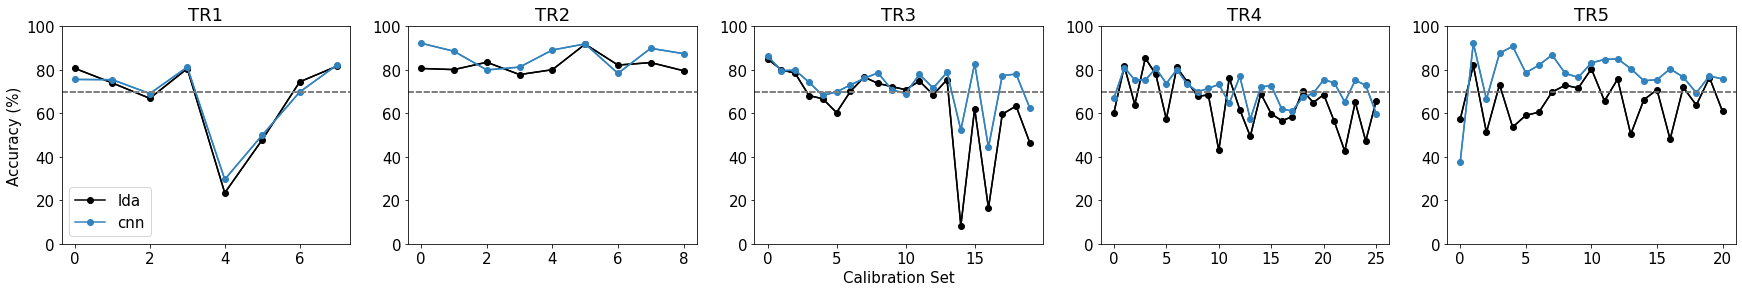

In [56]:
cv_iter = 1
fig,ax = plt.subplots(1,5,figsize=(30,4))
for sub in range(0,5):
    with open(subs[sub] + '_0_r_accs.p','rb') as f:
        # acc_all, recal_all = pickle.load(f)
        acc_all, recal_all, cur_all, prev_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

    # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
    colors =  cm.get_cmap('tab20c')
    c = np.empty((20,4))
    for i in range(20):
        c[i,:] = colors(i*1/20)


    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
    nn_c[0,-1] = 1
    all_m = ['ko-','o-','o-','s-','s-','v-','v-']
    pt_m = ['ko-','o-','o-','o-','s','s','s','s','D']
    nn_c = np.vstack((np.array([0,0,0,1]), c[0,:],c[1,:],c[2,:],c[3,:],c[4,:],c[5,:],c[6,:],c[0,:],c[8,:],c[0,:]))
    # nn_c[0,-1] = 1

    labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
    labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
    # labels = mod_tot

    ax_ind = sub
    it = 0
    for v in [1,2]: 
        i = mod_tot.index(mod_all[v])
        acc_temp = acc_all[1:-1,i]
        if not np.isnan(acc_temp).all():
            x = np.arange(len(acc_temp))
            recal_i = (acc_temp < 0)
            ax[ax_ind].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
            ax[ax_ind].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v],color=nn_c[it,:])
            ax[ax_ind].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
            it+=1

    for i in range(5):
        ax[i].axhline(70, ls='--', color='grey')
        
        ax[i].set_ylim([0,100])
        ax[i].set_title('TR' + str(i+1))
    ax[0].legend()
    ax[2].set_xlabel('Calibration Set')
    ax[0].set_ylabel('Accuracy (%)')
    plt.rc('font', size=15) 

In [ ]:
cv_iter = 1
for sub in range(0,5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [1,0,0,1,2,2,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[it]+': ' + str(int(recal_all[i,0])),color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
                it+=1

    for i in range(4):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

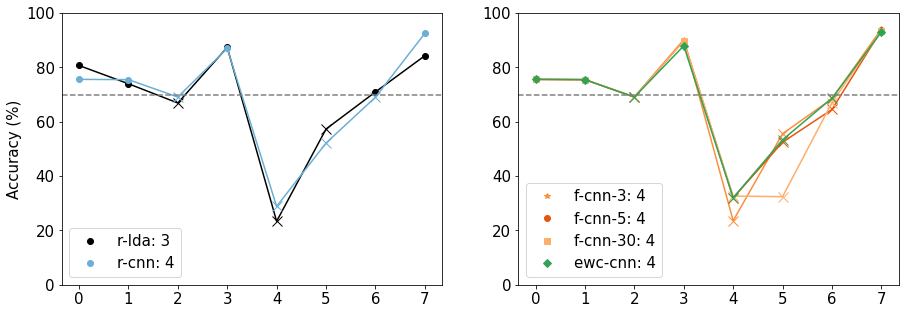

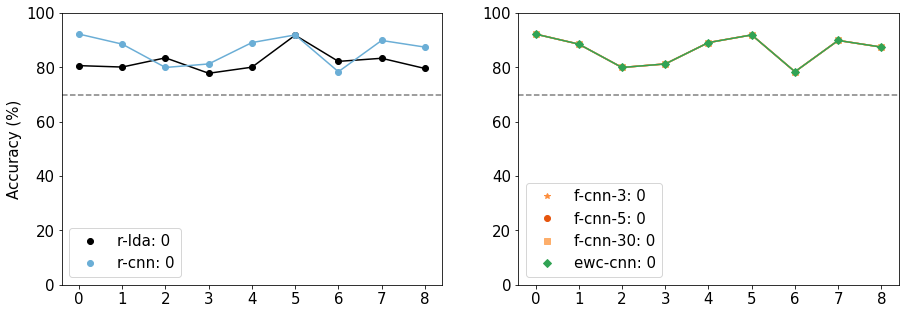

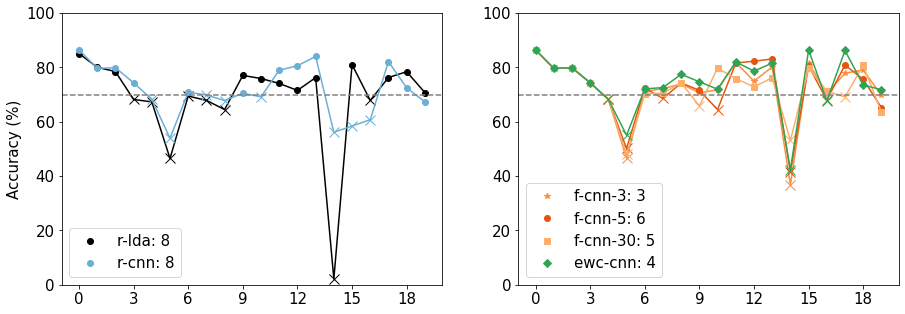

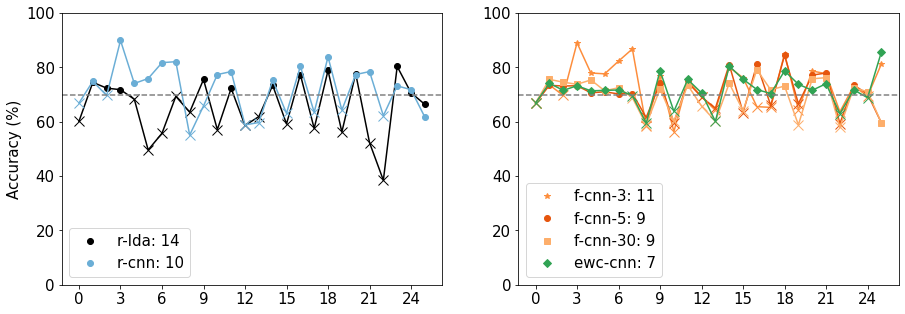

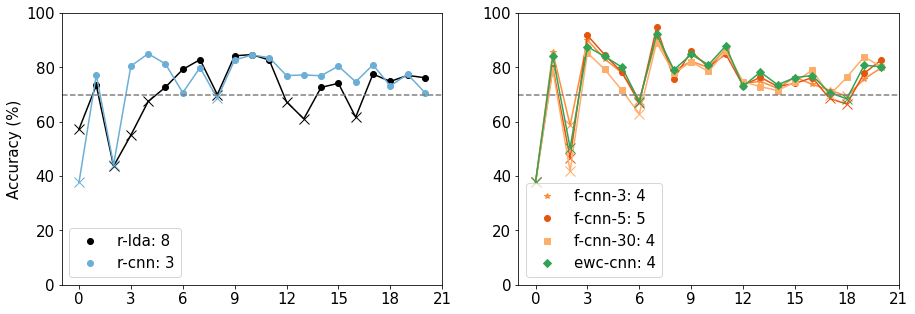

In [81]:
from matplotlib.ticker import MaxNLocator
cv_iter = 1
for sub in range(0,5):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','*','o','s','D','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        labels = ['r-lda','lda','cnn','r-cnn','f-cnn-5','f-cnn-3','f-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in [0, 3, 5, 4, 6, 7]: #range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v]+': ' + str(int(recal_all[i,0])),color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[v,:])
                ax[ax_ind[it]].xaxis.set_major_locator(MaxNLocator(integer=True))
                it+=1

    for i in range(2):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
        

    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
cv_iter = 5
for sub in [0,2]:#range(1):#5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(1,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)

        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','o','s','s','v','v','D','D','D']

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']

        # d0 = datetime(int(all_files[0][:4]),int(all_files[0][4:6]),int(all_files[0][6:8]),int(all_files[0][9:11]),int(all_files[0][11:13]),int(all_files[0][13:]))
        # delta = np.empty((len(acc_all)-1,1))
        # for i in range(1,len(acc_all)-1):
        #     d1 = datetime(int(all_files[i][:4]),int(all_files[i][4:6]),int(all_files[i][6:8]),int(all_files[i][9:11]),int(all_files[i][11:13]),int(all_files[i][13:]))
        #     delta[i] = (d1 - d0).total_seconds()
            
        ax_ind = [0,0,0,1,1,2,2,3,3,3]
        for i in [0,2,4,6,8,9]:#range(3):#acc_all.shape[-1]):
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[i]].plot(np.abs(acc_temp),'-',color=nn_c[i,:])
                ax[ax_ind[i]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[i],label=labels[i]+': ' + str(int(recal_all[i,0])),color=nn_c[i,:])
                ax[ax_ind[i]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[i,:])

    for i in range(4):
        ax[i].axhline(65, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
train_file = all_files[0]
train_file2 = all_files[1]
ft= 'feat'

train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [ ]:
train_data2, train_params2 = prd.load_caps_train(path + train_file2 + '/traindata.mat')
train_data2 = train_data2[:,:8,:]
train_data = np.vstack((train_data,train_data2))
train_params = np.vstack((train_params,train_params2))

In [ ]:
# Prep initial training data
ep = 30
n_dof = len(train_dof)

# train_data, train_params = prd.threshold(train_data, train_params)
trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=32,ft=ft, noise=True, split=False)
y_test_0, x_test_mlp_0, x_test_cnn_0, x_lda_0, y_lda_0 = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=False)


In [ ]:
# Initial training
mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=3)
mlp_0 = mlp.get_weights()
cnn_0 = cnn.get_weights()
w_0 = cp.deepcopy(w)
c_0 = cp.deepcopy(c)

In [ ]:
# LDA recalibration threshold
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)-1):
    # load data
    train_file = all_files[i]
    train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
    train_data = train_data[:,:8,:]
    # train_data, train_params = prd.threshold(train_data, train_params)

    train_dof = np.unique(train_params[:,2])
    key = np.empty(train_dof.shape)
    for ki in range(len(train_dof)):
        key[ki] = train_params[np.argmax(train_params[:,2] == train_dof[ki]),0]

    _, _, _, _, _, x_train_lda_0, y_train_lda_0, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=32, ft=ft, noise=False, split=False, emg_scale=np.ones((train_data.shape[1],1)))

    _, _, w, c = lp.train_models(x_train_lda=x_train_lda_0, y_train_lda=y_train_lda_0)

    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]

    # test_data, test_params = prd.threshold(test_data, test_params)
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, ft=ft, split=False)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, lda = [w, c])
    print ('Set: ' + test_file, f'LDA Accuracy: {acc[i,0]:.2f}')

In [ ]:
# Train and test on current dataset
acc = np.empty((len(all_files),5))
# old_train_mlp, old_train_cnn, old_x_train_lda, old_y_train_lda, old_y_train = [], [], [], [], []

for i in range(0,len(all_files)):
    train_file = all_files[i]
    train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
    train_data = train_data[:,:8,:]

    orig_train_dof = np.unique(train_params[:,2])
    train_data, train_params = prd.threshold(train_data, train_params)
    train_dof = np.unique(train_params[:,2])

    if len(orig_train_dof) == len(train_dof):
        n_dof = len(train_dof)
        key = np.empty(train_dof.shape)
        for key_i in range(len(train_dof)):
            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])

        trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=32, ft=ft, noise=False, split=True)

        if i > 0:
            x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, y_train_0 = np.vstack((old_train_mlp, x_train_mlp_0)), np.vstack((old_train_cnn, x_train_cnn_0)), np.vstack((old_x_train_lda, x_train_lda_0)), np.vstack((old_y_train_lda, y_train_lda_0)), np.vstack((old_y_train, y_train_0))

            trainmlp_0 = tf.data.Dataset.from_tensor_slices((x_train_mlp_0, y_train_0, y_train_0)).shuffle(x_train_mlp_0.shape[0],reshuffle_each_iteration=True).batch(32)
            traincnn_0 = tf.data.Dataset.from_tensor_slices((x_train_cnn_0, y_train_0, y_train_0)).shuffle(x_train_cnn_0.shape[0],reshuffle_each_iteration=True).batch(32)

        mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=30)

        # test 
        y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=True)
        acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
        print ('Set: ' + train_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')
        old_train_mlp, old_train_cnn, old_x_train_lda, old_y_train_lda, old_y_train = x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, y_train_0
    else:
        print('Skipping ' + train_file)

In [ ]:
# Train on initial, test without recalibration or adaptation
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]

    # test_data, test_params = prd.threshold(test_data, test_params)
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=False)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')

In [ ]:
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0,y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_val_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_val_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0,y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_val_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w, c], ewc, ewc_cnn)
print(ewc_acc[0,:])

for i in range(1,len(all_files)-1,1):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_val_ewc_cnn, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_val_ewc, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    # check class labels
    orig_train_dof = np.unique(ewc_params[:,2])
    ewc_data, ewc_params = prd.threshold(ewc_data, ewc_params)
    train_dof = np.unique(ewc_params[:,2])

    if len(orig_train_dof) == len(train_dof):
        # n_dof = len(train_dof)
        
        # training data
        ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
        # training data for recalibration
        rmlp, rcnn, y_train_r, x_train_r, x_train_r_cnn, x_train_r_lda, y_train_r_lda, r_emg_scale, r_scaler, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, batch_size=32, noise=True, ft=ft, split=True)
        # validation data for fisher
        _, _, y_val_ewc, x_val_ewc, x_val_ewc_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
        # test data
        y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft,split=True)
        # test data for recalibration
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(ewc_data, ewc_params, r_scaler, r_emg_scale, ft=ft,split=True)

        loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        mlp, cnn, _, _ = lp.train_models(ewccnn, ewcmlp, n_dof=n_dof, ep=5, mlp=mlp, cnn=cnn)

        mlp_r, cnn_r, w, c = lp.train_models(rcnn, rmlp, x_train_r_lda, y_train_r_lda, n_dof=n_dof, ep=30)

        # test
        ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
        x_test_ewc_0 = cp.deepcopy(x_test_ewc)
        y_test_ewc_0 = cp.deepcopy(y_test_ewc)

        print ('EWC: ' + ewc_file + ',', f'EWC CNN Accuracy: {ewc_acc[i,4]:.2f},', f'EWC Accuracy: {ewc_acc[i,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i,1]:.2f},', f'r-LDA Accuracy: {rec_acc[i,0]:.2f}')
    else:
        print('Skipping ' + ewc_file)

In [ ]:
# Test all controllers with ewc
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0, y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_val_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_val_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0, y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_val_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w_0, c_0], ewc, ewc_cnn)

for i in range(7,len(all_files)-1,2):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_val_ewc_cnn, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_val_ewc, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    orig_train_dof = np.unique(ewc_params[:,2])
    ewc_data, ewc_params = prd.threshold(ewc_data, ewc_params)
    train_dof = np.unique(ewc_params[:,2])

    if len(orig_train_dof) == len(train_dof):

        # check class labels
        ewc_data, ewc_params = lp.check_labels(ewc_data, ewc_params, train_dof, key)
        
        ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft, split=True)
        _, _, y_val_ewc, x_val_ewc, x_val_ewc_cnn, _, _, _, _, _, _, _= prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft, split=True)

        y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft, split=True)

        loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        mlp, cnn, _, _ = lp.train_models(ewccnn, ewcmlp, x_train_lda, y_train_lda, n_dof, 30, mlp, cnn)
        
        # training data for recalibration
        rmlp, rcnn, y_train_r, x_train_r, x_train_r_cnn, x_train_r_lda, y_train_r_lda, r_emg_scale, r_scaler, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, batch_size=32, noise=True, ft=ft, split=True)
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(ewc_data, ewc_params, r_scaler, r_emg_scale, ft=ft, split=True)

        mlp_r, cnn_r, w, c = lp.train_models(rcnn, rmlp, x_train_r_lda, y_train_r_lda, ep=30)

        # load test data
        test_file = all_files[i+1]
        test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
        test_data = test_data[:,:8,:]
        
        # check class labels
        test_data, test_params = prd.threshold(test_data, test_params)
        test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

        ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        # test 
        y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft)
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(test_data, test_params, r_scaler, r_emg_scale, num_classes=n_dof,ft=ft)
        ewc_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i+1,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
        x_test_ewc_0 = cp.deepcopy(x_test_ewc)
        y_test_ewc_0 = cp.deepcopy(y_test_ewc)

        print ('EWC: ' + ewc_file + ', Test: ' + test_file + ',', f'EWC CNN Accuracy: {ewc_acc[i+1,4]:.2f},', f'EWC Accuracy: {ewc_acc[i+1,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i+1,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i+1,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i+1,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i+1,1]:.2f},', f'r-LDA Accuracy: {rec_acc[i+1,0]:.2f}')
    else:
        print('Skipping: ' + ewc_file)

In [ ]:
ewc_acc[0,...] = np.nan
rec_acc[0,...] = np.nan
rlda_acc = np.empty((len(all_files),15))
rlda_acc[:] = np.nan
lda_acc = np.empty((len(all_files),15))
lda_acc[:] = np.nan
acc_all = np.hstack((acc[:,...],ewc_acc,rec_acc))
for i in range(acc.shape[1]):
    rlda_acc[:,i] = acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+5] = ewc_acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+10] = rec_acc[:,i] - ewc_acc[:,0]

    lda_acc[:,i] = acc[:,i] - acc[:,0]
    lda_acc[:,i+5] = ewc_acc[:,i] - acc[:,0]
    lda_acc[:,i+10] = rec_acc[:,i] - acc[:,0]

In [ ]:
lda_i = [0, 5]
cnn_i = [2, 12, 7, 9]
mlp_i = [1, 11, 6, 8]
nn_i = np.vstack((mlp_i,cnn_i))

colors =  cm.get_cmap('tab20c')
c = np.empty((20,4))
for i in range(20):
    c[i,:] = colors(i*1/20)

mlp_c = np.vstack((c[8,:],c[9,:],c[10,:],c[11,:]))
cnn_c = np.vstack((c[0,:],c[1,:],c[2,:],c[3,:]))
nn_c = np.stack((mlp_c,cnn_c))
lda_c = ['ko-','ko--']
nn_m = ['o-','s-','v-','x-']

In [ ]:
mask = ~np.isnan(rlda_acc)

for mod in range(nn_i.shape[0]):
    i_ = nn_i[mod,...]
    fig,ax = plt.subplots(1,3,figsize=(16,4))

    # for i in range(len(lda_i)):
        # ax[0].plot(acc_all[mask[:,lda_i[i]],lda_i[i]][1::2], lda_c[i])
    for i in range(len(i_)):
        ax[0].plot(acc_all[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])
        ax[1].plot(rlda_acc[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])
        ax[2].plot(lda_acc[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])

    if mod == 0:
        ax[0].legend(['LDA', 'r-LDA', 'MLP', 'r-MLP', 'a-MLP', 'ewc-MLP'])
        ax[1].legend(['MLP vs. r-LDA', 'r-MLP vs. r-LDA', 'a-MLP vs. r-LDA', 'ewc-MLP vs. r-LDA'])
        ax[2].legend(['MLP vs. LDA', 'r-MLP vs. LDA', 'a-MLP vs. LDA', 'ewc-MLP vs. LDA'])
    else:
        ax[0].legend(['LDA', 'r-LDA', 'CNN', 'r-CNN', 'a-CNN', 'ewc-CNN'])
        ax[1].legend(['CNN vs. r-LDA', 'r-CNN vs. r-LDA', 'a-CNN vs. r-LDA', 'ewc-CNN vs. r-LDA'])
        ax[2].legend(['CNN vs. LDA', 'r-CNN vs. LDA', 'a-CNN vs. LDA', 'ewc-CNN vs. LDA'])

    ax[0].set_ylim([0,100])
    ax[1].axhline(0, ls = '--',color='black')
    ax[2].axhline(0, color='black')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o', label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-')

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls)

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-')

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o',color=col[i,:], label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-',color=col[i,:])

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls,color=col[i,:])

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-',color=col[i,:])

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
# Test all controllers with adaptation
ep = 30
# Remove extra file if odd number of files
# if len(all_files)%2 == 0:
#     all_files = np.delete(all_files,-1)
align_acc = np.empty((len(all_files),5))
align_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(2,len(all_files)-1):
    # load recalibration data
    align_file = all_files[i]
    align_data, align_params = prd.load_caps_train(path + align_file + '/traindata.mat')
    align_data = align_data[:,:8,:]

    # check class labels
    align_data, align_params = prd.threshold(align_data, align_params)
    align_data, align_params = lp.check_labels(align_data, align_params, train_dof, key)
    
    alignmlp, aligncnn, _, _, _, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(align_data, align_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
    mlp, cnn, mlp_ali, cnn_ali, w, c = lp.train_models(aligncnn, alignmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn, align=True)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(align_data, align_params, scaler, emg_scale, num_classes=n_dof,ft=ft, split=True)
    align_acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c], cnn_align=cnn_ali, mlp_align=mlp_ali)

    print ('Align: ' + align_file + ',', f'CNN Accuracy: {align_acc[i,2]:.2f},', f'MLP Accuracy: {align_acc[i,1]:.2f},', f'LDA Accuracy: {align_acc[i,0]:.2f}')